# Train Likelihood Ratio Estimator 

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.DEBUG)

## Prepare Training and Testing Datasets

In [8]:
sampler = SampleAugmenter('meta/delphes_data_shuffled_g02.h5')
miner = MadMiner()
miner.load('meta/setup.h5')

# 300, 0
training_theta_ref = 'benchmark_55'
# 285, .8
testing_theta_true = 'benchmark_26'

# Remove 0 coupling points from training

#Train Sample
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.benchmarks(miner.benchmarks.keys()),
    theta1=sampling.benchmark(training_theta_ref),
    n_samples=2000000,
    folder='./meta/samples',
    filename='train_ratio',
)

# Calibration Sample
_ = sampler.sample_test(
    theta=sampling.benchmark(training_theta_ref),
    n_samples=20000,
    folder='./meta/samples',
    filename='calibrate'
)


19:44 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled_g02.h5
19:44 madminer.analysis    INFO    Found 2 parameters
19:44 madminer.analysis    INFO    Did not find nuisance parameters
19:44 madminer.analysis    INFO    Found 121 benchmarks, of which 121 physical
19:44 madminer.analysis    INFO    Found 8 observables
19:44 madminer.analysis    INFO    Found 649198 events
19:44 madminer.analysis    INFO    Did not find morphing setup.
19:44 madminer.analysis    INFO    Did not find nuisance morphing setup
19:44 madminer.core        INFO    Found 2 parameters:
19:44 madminer.core        INFO       mzp (LHA: mass 56, maximal power in squared ME: (0,), range: (275.0, 325.0))
19:44 madminer.core        INFO       gzp (LHA: dminputs 2, maximal power in squared ME: (0,), range: (0.0, 2.0))
19:44 madminer.core        INFO    Found 121 benchmarks:
19:44 madminer.core        INFO       benchmark_0: mzp = 2.75e+02, gzp = 0.00e+00
19:44 madminer.core        INFO       bench

19:44 madminer.core        INFO       benchmark_93: mzp = 3.15e+02, gzp = 1.00
19:44 madminer.core        INFO       benchmark_94: mzp = 3.15e+02, gzp = 1.20
19:44 madminer.core        INFO       benchmark_95: mzp = 3.15e+02, gzp = 1.40
19:44 madminer.core        INFO       benchmark_96: mzp = 3.15e+02, gzp = 1.60
19:44 madminer.core        INFO       benchmark_97: mzp = 3.15e+02, gzp = 1.80
19:44 madminer.core        INFO       benchmark_98: mzp = 3.15e+02, gzp = 2.00
19:44 madminer.core        INFO       benchmark_99: mzp = 3.20e+02, gzp = 0.00e+00
19:44 madminer.core        INFO       benchmark_100: mzp = 3.20e+02, gzp = 0.20
19:44 madminer.core        INFO       benchmark_101: mzp = 3.20e+02, gzp = 0.40
19:44 madminer.core        INFO       benchmark_102: mzp = 3.20e+02, gzp = 0.60
19:44 madminer.core        INFO       benchmark_103: mzp = 3.20e+02, gzp = 0.80
19:44 madminer.core        INFO       benchmark_104: mzp = 3.20e+02, gzp = 1.00
19:44 madminer.core        INFO       bench

In [107]:
# Test Sample
_ = sampler.sample_test(
    theta=sampling.benchmark(testing_theta_true),
    n_samples=10000,
    folder='./meta/samples',
    filename='test'
)

00:45 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to benchmark_26
00:45 madminer.sampling    INFO    Starting sampling serially
00:45 madminer.sampling    INFO    Sampling from parameter point 1 / 1
00:45 madminer.sampling    INFO    Effective number of samples: 114.39752784824984


## Train Estimator

In [9]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(10,10,10,10,10),
    activation="relu",
)

learning_rates = np.logspace(-7,0,21)
validation_losses = []

print(learning_rates)

for alpha in learning_rates:
    train_loss, val_loss = estimator.train(
        method='rolr',
        theta='meta/samples/theta0_train_ratio.npy',
        x='meta/samples/x_train_ratio.npy',
        y='meta/samples/y_train_ratio.npy',
        r_xz='meta/samples/r_xz_train_ratio.npy',
        initial_lr = alpha,
        batch_size = 5000,
        limit_samplesize=200000,
        optimizer='adam',
        n_epochs=10
    )
    validation_losses += [val_loss.mean()]
    
plt.plot(learning_rates, validation_losses, 'k-')
plt.xscale('log')
plt.show()
estimator.save('models/rolr')

19:54 madminer.ml          INFO    Starting training
19:54 madminer.ml          INFO      Method:                 rolr
19:54 madminer.ml          INFO      Batch size:             5000
19:54 madminer.ml          INFO      Optimizer:              adam
19:54 madminer.ml          INFO      Epochs:                 10
19:54 madminer.ml          INFO      Learning rate:          1e-07 initially, decaying to 0.0001
19:54 madminer.ml          INFO      Validation split:       0.25
19:54 madminer.ml          INFO      Early stopping:         True
19:54 madminer.ml          INFO      Scale inputs:           True
19:54 madminer.ml          INFO      Shuffle labels          False
19:54 madminer.ml          INFO      Samples:                200000
19:54 madminer.ml          INFO    Loading training data
19:54 madminer.ml          INFO    Found 1999888 samples with 2 parameters and 8 observables
19:54 madminer.ml          INFO    Only using 200000 of 1999888 training samples
19:54 madminer.ml       

[1.00000000e-07 2.23872114e-07 5.01187234e-07 1.12201845e-06
 2.51188643e-06 5.62341325e-06 1.25892541e-05 2.81838293e-05
 6.30957344e-05 1.41253754e-04 3.16227766e-04 7.07945784e-04
 1.58489319e-03 3.54813389e-03 7.94328235e-03 1.77827941e-02
 3.98107171e-02 8.91250938e-02 1.99526231e-01 4.46683592e-01
 1.00000000e+00]


KeyboardInterrupt: 

In [18]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(60,60,60),
    activation="relu",
)

train_loss, val_loss = estimator.train(
    method='rolr',
    theta='meta/samples/theta0_train_ratio.npy',
    x='meta/samples/x_train_ratio.npy',
    y='meta/samples/y_train_ratio.npy',
    r_xz='meta/samples/r_xz_train_ratio.npy',
    initial_lr = .002,
    final_lr = .0005,
    batch_size = 1000,
    limit_samplesize=200000,
    optimizer='adam',
    n_epochs=50
)
    
estimator.save('models/rolr')

00:25 madminer.ml          INFO    Starting training
00:25 madminer.ml          INFO      Method:                 rolr
00:25 madminer.ml          INFO      Batch size:             1000
00:25 madminer.ml          INFO      Optimizer:              adam
00:25 madminer.ml          INFO      Epochs:                 50
00:25 madminer.ml          INFO      Learning rate:          0.002 initially, decaying to 0.0005
00:25 madminer.ml          INFO      Validation split:       0.25
00:25 madminer.ml          INFO      Early stopping:         True
00:25 madminer.ml          INFO      Scale inputs:           True
00:25 madminer.ml          INFO      Shuffle labels          False
00:25 madminer.ml          INFO      Samples:                200000
00:25 madminer.ml          INFO    Loading training data
00:25 madminer.ml          INFO    Found 1999888 samples with 2 parameters and 8 observables
00:25 madminer.ml          INFO    Only using 200000 of 1999888 training samples
00:25 madminer.ml       

## Evaluate Likelihood Ratio Estimator

Define grid that neural network will be evaluated on (does NOT need to be made of only benchmark points - the NN can interpolate in theta space now).

In [21]:
grid_res = 26
asimov_n = 500

theta_m = np.linspace(275.,325.,grid_res)
theta_g = np.linspace(0.,2.,grid_res)
theta0_new, theta1_new = np.meshgrid(theta_m, theta_g)
theta_grid = np.vstack((theta0_new.flatten(), theta1_new.flatten())).T
np.save('meta/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[300.,0.]])
np.save('meta/samples/theta_ref.npy', theta_denom)

Evaluate the log likelihood ratio of the test set at each point in the grid using the newly trained neural network.

In [22]:
estimator.load('models/rolr')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='meta/samples/theta_grid.npy',
    x='meta/samples/x_test.npy',
    evaluate_score=False
)

Evaluate the log likelihood ratio of a dataset drawn from the reference theory to be used for expectation calibration (see guide to constraining EFTs with machine learning, equations 43 and 44).

In [23]:
# Calibration
log_r_hat_calibrate, _ = estimator.evaluate_log_likelihood_ratio(
    theta='meta/samples/theta_grid.npy',
    x='meta/samples/x_calibrate.npy',
    evaluate_score=False
)

calibration_diff = np.log(np.mean(np.exp(log_r_hat_calibrate), axis=1))
calibrated_llr = (log_r_hat.T - calibration_diff).T

Plot results:

1: Calibrated p values over $\theta$ space

2: Uncalibrated p values over $\theta$ space

3: Expected Calibrated LLR over $\theta$ space.

[325.     0.56]
OrderedDict([(u'mzp', 285.0), (u'gzp', 0.8)])


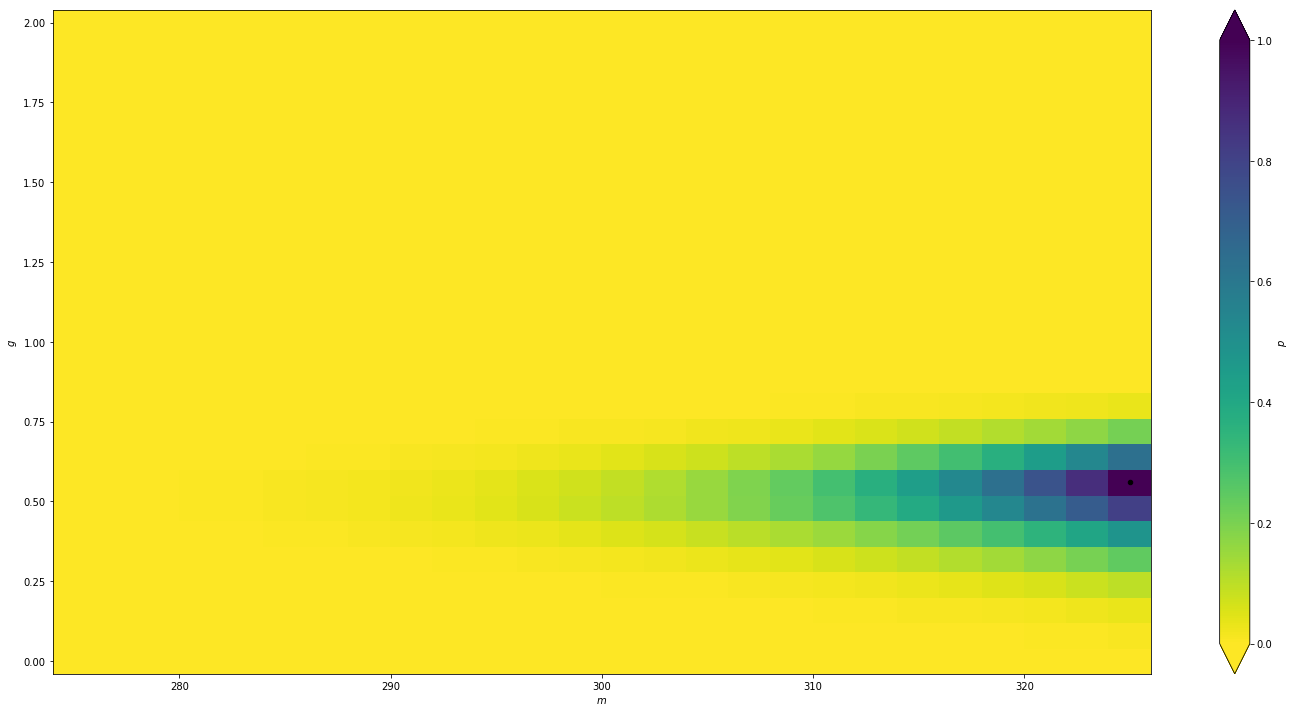

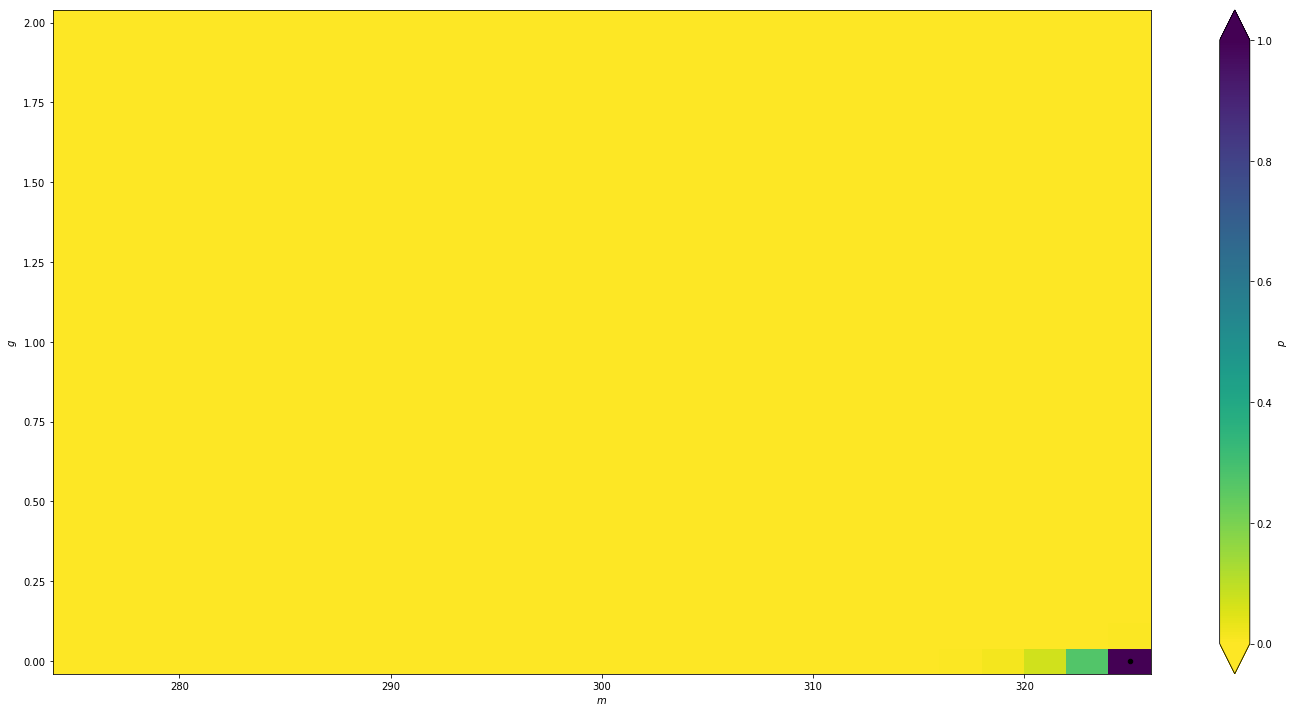

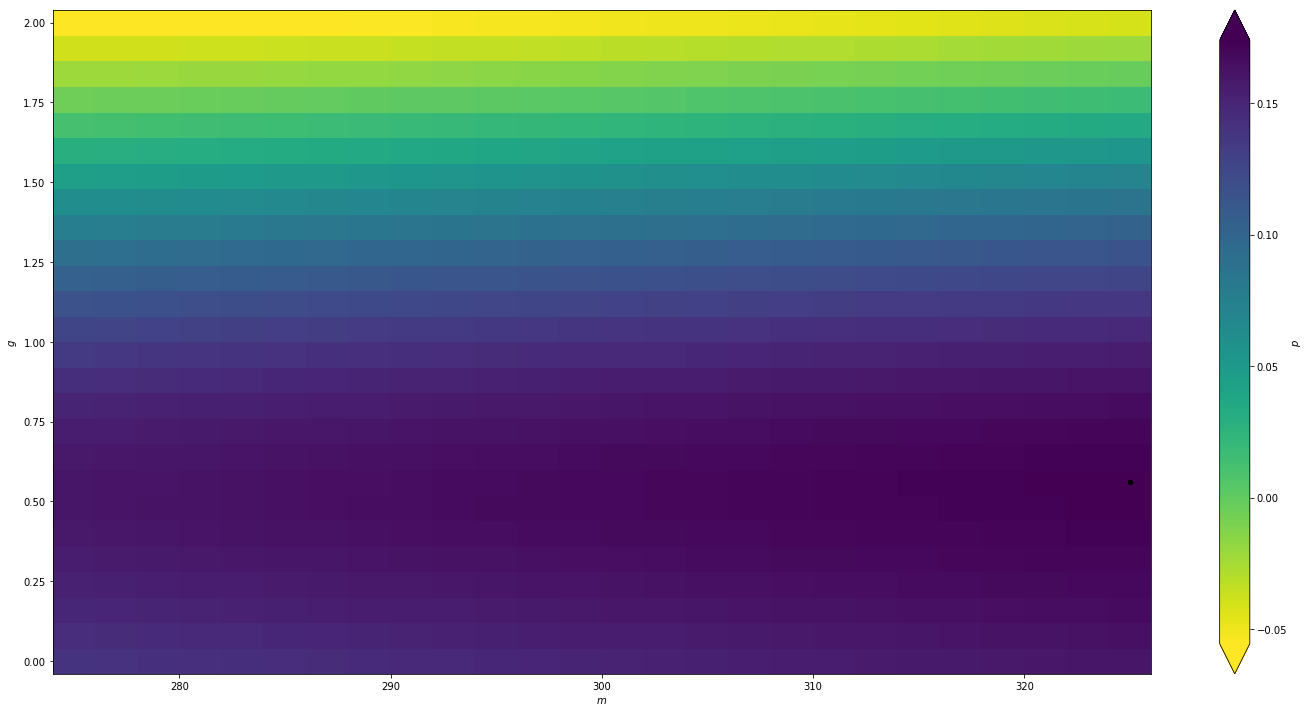

In [24]:
bin_size_m = theta_m[1] - theta_m[0]
edges_m = np.linspace(theta_m[0] - bin_size_m/2, theta_m[-1] + bin_size_m/2, len(theta_m)+1)
bin_size_g = theta_g[1] - theta_g[0]
edges_g = np.linspace(theta_g[0] - bin_size_g/2, theta_g[-1] + bin_size_g/2, len(theta_g)+1)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()


expected_llr = np.mean(calibrated_llr ,axis=1)
best_fit = theta_grid[np.argmax(expected_llr)]

print(best_fit)
print(miner.benchmarks[testing_theta_true])

log_r_hat_wrt_mle = calibrated_llr - calibrated_llr[np.argmax(expected_llr)]
pvals = np.exp(asimov_n * np.mean(log_r_hat_wrt_mle, axis=1))

cmin, cmax = np.min(pvals), np.max(pvals)

pcm = ax.pcolormesh(edges_m, edges_g, pvals.reshape((grid_res,grid_res)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='.')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

expected_llr = np.mean(log_r_hat ,axis=1)
best_fit = theta_grid[np.argmax(expected_llr)]

log_r_hat_wrt_mle = log_r_hat - log_r_hat[np.argmax(expected_llr)]
pvals = np.exp(asimov_n * np.mean(log_r_hat_wrt_mle, axis=1))

cmin, cmax = np.min(pvals), np.max(pvals)

pcm = ax.pcolormesh(edges_m, edges_g, pvals.reshape((grid_res,grid_res)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='.')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(20,10))
ax = plt.gca()


expected_llr = np.mean(calibrated_llr ,axis=1)
best_fit = theta_grid[np.argmax(expected_llr)]

cmin, cmax = np.min(expected_llr), np.max(expected_llr)

pcm = ax.pcolormesh(edges_m, edges_g, expected_llr.reshape((grid_res,grid_res)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='.')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()

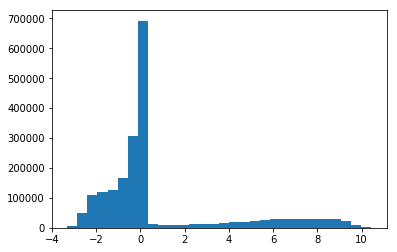

[      8      20      23 ... 1999874 1999877 1999881]
[ 4.00307894  2.84056282 30.33362007  5.7988553  -0.75529575  0.10511542
 25.7375946   6.42122602]
[0.97149849]


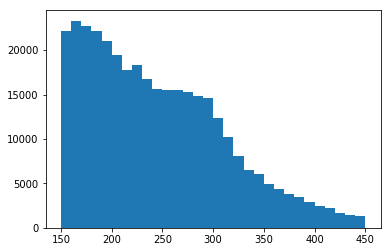

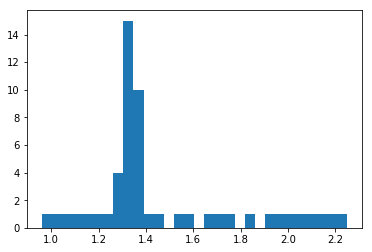

-1.7323881 3.3196251
-3.3099783971118586 10.440959633152376


In [30]:
plt.hist(np.log(r_xz), bins=30)
plt.show()

print(np.where(r_xz > np.exp(4))[0])
print(x[12])
print(r_xz[12])

def calc_inv_mass(all_x):
    eta0 = all_x[:,0]
    phi0 = all_x[:,1]
    pt0  = all_x[:,2]
    m0   = all_x[:,3]
    eta1 = all_x[:,4]
    phi1 = all_x[:,5]
    pt1  = all_x[:,6]
    m1   = all_x[:,7]
    return  np.sqrt(2 * np.abs(pt0) * np.abs(pt1) * (np.cosh(eta0 - eta1) - np.cos(phi0-phi1)))

mz300gzp1 = np.where(np.equal(theta0[:,0], 300.) + np.equal(theta0[:,1],1.))[0]
plt.hist(calc_inv_mass(x[mz300gzp1]), bins=30)
plt.show()

plt.hist(calibrated_llr[np.where(theta_grid==[285., .8])], bins=30)
plt.show()

print(calibrated_llr.min(), calibrated_llr.max())
print(np.log(r_xz.min()), np.log(r_xz.max()))